In [26]:
import os
import math
import numpy as np
import pandas as pd

In [27]:
dataset_dir = r'E:\juno\highlight_generator\data\dataset'
ckpt_dir = 'checkpoints'

In [28]:
learning_rate = 1e-4
epochs = 25
batch_size = 256
class_weights = (1, 1)
x_includes = ['video', 'audio']

# for basic model
# x_expand = 0
# for sequence model
x_expand = 2    # 앞 2개, 뒤 2개 segment 포함

In [29]:
from data_loader import DataLoader

data_loader = DataLoader(dataset_dir, x_includes=x_includes, x_expand=x_expand)

data_config = data_loader.get_metadata()['config']
input_shape_dict = data_loader.get_metadata()['data_shape']

In [36]:
from tensorflow.keras.layers import Dense, Dropout, Conv3D, Conv2D, Input, MaxPool3D, MaxPool2D, Flatten, concatenate, Reshape
from tensorflow.keras.layers import TimeDistributed, LSTM, GRU, Bidirectional, ConvLSTM2D, Lambda
from tensorflow.keras.backend import expand_dims
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
import tensorflow as tf

def build_basic_model():
    video_input_shape = input_shape_dict['video']
    audio_input_shape = input_shape_dict['audio']
    weight_decay = 0.005

    # Video 3D Conv layers
    video_input = Input(video_input_shape, name='video_input')
    x = video_input
    x = Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same')(x)
    video_output = Flatten(name='video_output')(x)
    
    video_model = Model(inputs=video_input, outputs=video_output)

    # Audio 2D Conv layers
    audio_input = Input(audio_input_shape, name='audio_input')
    x = Reshape(audio_input_shape + [1])(audio_input)    # add channel dim
    x = Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    x = MaxPool2D((2, 2), strides=(2, 2), padding='same')(x)
    audio_output = Flatten(name='audio_output')(x)
    
    audio_model = Model(inputs=audio_input, outputs=audio_output)
    
    # Make video/audio combined model for saving after train
    combined_output = concatenate([video_output, audio_output])
    
    combined_model = Model(inputs=[video_input, audio_input], outputs=combined_output)

    # Fully-connected layers
    x = combined_output
    x = Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    # Make entire model for training
    entire_model = Model(inputs=[video_input, audio_input], outputs=fc_output)

    return video_model, audio_model, combined_model, entire_model

def build_sequence_model():
    video_input_shape = [None] + input_shape_dict['video']
    audio_input_shape = [None] + input_shape_dict['audio']
    weight_decay = 0.005

    # Video 3D Conv layers
    video_input = Input(video_input_shape)
    x = video_input
    x = TimeDistributed(Conv3D(8, (3, 3, 3), strides=(1, 1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x)
    x = TimeDistributed(MaxPool3D((2, 2, 2), strides=(2, 2, 2), padding='same'))(x)
    video_output = TimeDistributed(Flatten())(x)
    
    # Audio 2D Conv layers
    audio_input = Input(audio_input_shape)
    # x = Reshape(audio_input_shape + [1])(audio_input) # add channel dim
    x = TimeDistributed(Lambda(lambda x: tf.expand_dims(x, axis=-1)))(audio_input)  # add channel dim -> 추가한 부분
    x = TimeDistributed(Conv2D(4, (3, 3), strides=(1, 1), padding='same', activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x)
    x = TimeDistributed(MaxPool2D((2, 2), strides=(2, 2), padding='same'))(x)
    audio_output = TimeDistributed(Flatten())(x)
    
    # LSTM layers
    x = concatenate([video_output, audio_output])
    x = LSTM(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    # x = Bidirectional(LSTM(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x) # LSTM -> Bi-LSTM
    # x = Bidirectional(GRU(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x) # LSTM -> GRU
    
    # Fully-connected layers
    x = Dense(16, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    #     x = Dropout(0.2)(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    model = Model(inputs=[video_input, audio_input], outputs=fc_output)

    return model

def build_sequence_model_with_pretrained(checkpoint_name):
    video_input_shape = input_shape_dict['video']
    audio_input_shape = input_shape_dict['audio']
    video_seq_input_shape = [None] + video_input_shape
    audio_seq_input_shape = [None] + audio_input_shape
    weight_decay = 0.005

    # Load pretrained models
    saved_model_name = checkpoint_name + '_model'
    video_model_name = saved_model_name + '_video'
    audio_model_name = saved_model_name + '_audio'
    video_model_path = os.path.join(ckpt_dir, video_model_name + '.h5')
    audio_model_path = os.path.join(ckpt_dir, audio_model_name + '.h5')

    video_model = load_model(video_model_path)
    audio_model = load_model(audio_model_path)
    video_model.trainable = audio_model.trainable = False

    # Input layers
    video_seq_input = Input(video_seq_input_shape)
    audio_seq_input = Input(audio_seq_input_shape)

    # Combine video/audio layers
    video_seq_output = TimeDistributed(video_model)(video_seq_input)
    audio_seq_output = TimeDistributed(audio_model)(audio_seq_input)
    combined_seq_output = concatenate([video_seq_output, audio_seq_output])
    
    # LSTM layers
    x = combined_seq_output
    x = LSTM(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    # x = Bidirectional(LSTM(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x) # LSTM -> Bi-LSTM
    # x = Bidirectional(GRU(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay)))(x) # LSTM -> GRU
    
    # Fully-connected layers
    x = Dense(32, activation='relu', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)
    #     x = Dropout(0.2)(x)
    fc_output = Dense(1, activation='sigmoid', kernel_initializer='he_uniform', kernel_regularizer=l2(weight_decay))(x)

    model = Model(inputs=[video_seq_input, audio_seq_input], outputs=fc_output)

    return model

Model: "model_2"
________________________________________________________________________________________________________________________________________
 Layer (type)                               Output Shape                  Param #          Connected to                                 
 input_18 (InputLayer)                      [(None, None, 40, 108)]       0                []                                           
                                                                                                                                        
 input_17 (InputLayer)                      [(None, None, 15, 64, 64, 3)  0                []                                           
                                            ]                                                                                           
                                                                                                                                        
 time_distributed_37 (Ti

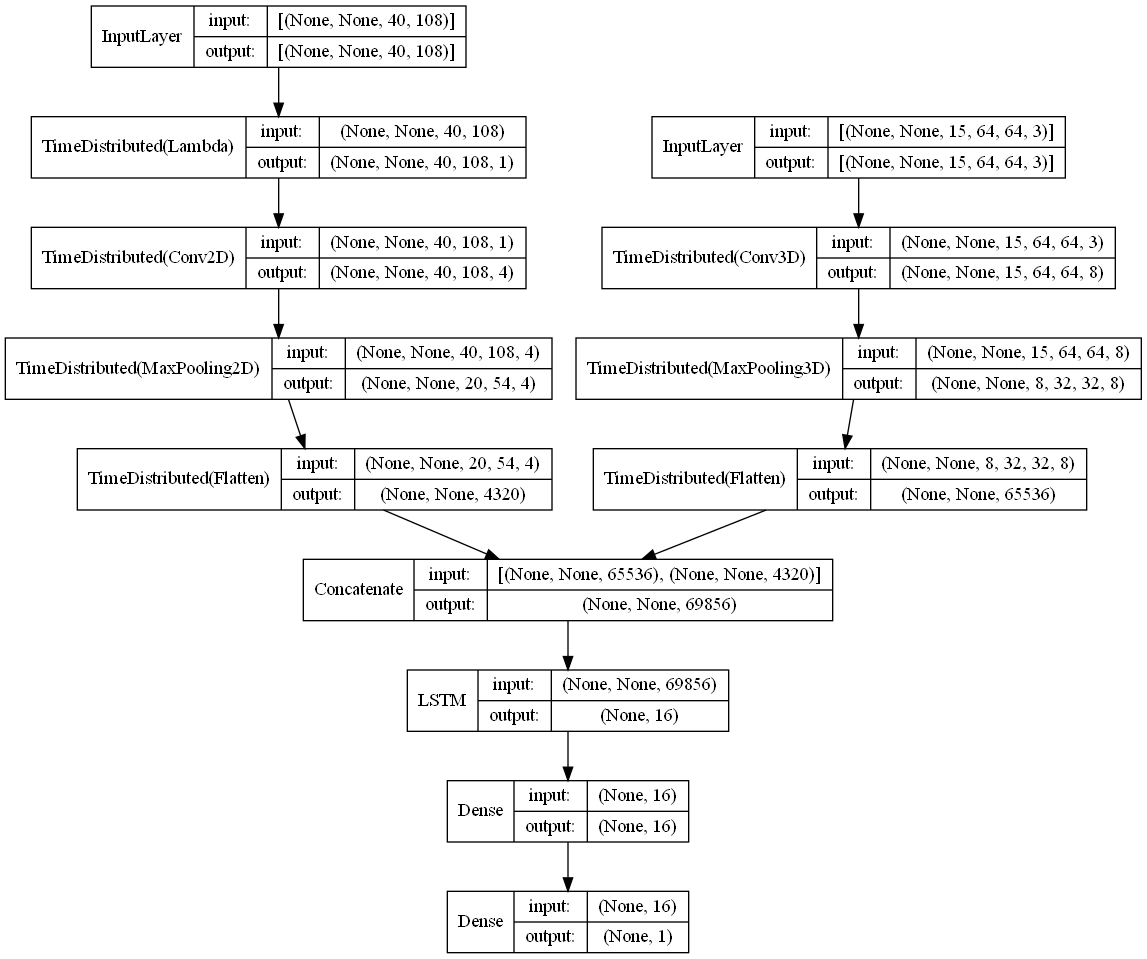

In [37]:
# for basic model
# video_model, audio_model, combined_model, model = build_basic_model()
# for sequence model
model = build_sequence_model()
# for sequence model with pretrained combined model
# model = build_sequence_model_with_pretrained('ckpt-20200825-163656-0002-0.3130-0.4588')

model.summary(line_length=136)
plot_model(model, show_shapes=True, show_layer_names=False)

In [ ]:
from trainer import Trainer
from tensorflow.keras.optimizers import Adam

# 학습 시작
trainer = Trainer(model, data_loader, ckpt_dir)
trainer.train(Adam(learning_rate), epochs, batch_size, class_weights)

Training started at 20230611-215541
optimizer: {'name': 'Adam', 'learning_rate': 0.0001, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
epochs: 25
batch size: 256
class weights: (1, 1)
normalized class weights: [1. 1.]



Train 1/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 1/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0001-0.2222.h5


Train 2/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 2/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0002-0.0556.h5


Train 3/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 3/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0003-0.3261.h5


Train 4/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 4/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0004-0.3711.h5


Train 5/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 5/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0005-0.4118.h5


Train 6/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 6/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0006-0.3830.h5


Train 7/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 7/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0007-0.4648.h5


Train 8/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 8/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0008-0.4202.h5


Train 9/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 9/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0009-0.4272.h5


Train 10/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 10/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0010-0.4685.h5


Train 11/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 11/25:   0%|          | 0/10 [00:00<?, ?it/s]

Train 12/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 12/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0012-0.5072.h5


Train 13/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 13/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0013-0.4602.h5


Train 14/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 14/25:   0%|          | 0/10 [00:00<?, ?it/s]

model saved to checkpoints\ckpt-20230611-215541-0014-0.4643.h5


Train 15/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 15/25:   0%|          | 0/10 [00:00<?, ?it/s]

Train 16/25:   0%|          | 0/72 [00:00<?, ?it/s]

Validation 16/25:   0%|          | 0/10 [00:00<?, ?it/s]

Train 17/25:   0%|          | 0/72 [00:00<?, ?it/s]

In [38]:
checkpoint_name = 'ckpt-20230611-182530-0022-0.5255'
model.load_weights(os.path.join(ckpt_dir, checkpoint_name + '.h5'))

In [39]:
from sklearn.metrics import confusion_matrix, classification_report
from trainer import Trainer

trainer = Trainer(model, data_loader, ckpt_dir)
y_true, y_pred = trainer.test_prediction(batch_size)

print(f'test data count: {len(y_true)}')
print(f'true_1, pred_1: {y_true.sum(), y_pred.sum()}')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Report:')
print(classification_report(y_true, y_pred))

Test:   0%|          | 0/10 [00:00<?, ?it/s]

test data count: 2364
true_1, pred_1: (70, 53)

Confusion Matrix:
[[2270   24]
 [  41   29]]

Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2294
           1       0.55      0.41      0.47        70

    accuracy                           0.97      2364
   macro avg       0.76      0.70      0.73      2364
weighted avg       0.97      0.97      0.97      2364



In [40]:
checkpoint_name = 'ckpt-20230611-182530-0022-0.5255'
model_name = checkpoint_name + '_model'
model_path = os.path.join(ckpt_dir, model_name + '.h5')
print(model_path)

video_model_name = model_name + '_video'
audio_model_name = model_name + '_audio'
combined_model_name = model_name + '_combined'
video_model_path = os.path.join(ckpt_dir, video_model_name + '.h5')
audio_model_path = os.path.join(ckpt_dir, audio_model_name + '.h5')
combined_model_path = os.path.join(ckpt_dir, combined_model_name + '.h5')
print(video_model_path)
print(audio_model_path)
print(combined_model_path)

checkpoints\ckpt-20230611-182530-0022-0.5255_model.h5
checkpoints\ckpt-20230611-182530-0022-0.5255_model_video.h5
checkpoints\ckpt-20230611-182530-0022-0.5255_model_audio.h5
checkpoints\ckpt-20230611-182530-0022-0.5255_model_combined.h5


In [41]:
model.save(model_path)

video_model.save(video_model_path)
audio_model.save(audio_model_path)
combined_model.save(combined_model_path)

In [42]:
checkpoint_name = 'ckpt-20230611-182530-0022-0.5255'
model_name = checkpoint_name + '_model'
model_path = os.path.join(ckpt_dir, model_name + '.h5')
print(model_path)

checkpoints\ckpt-20230611-182530-0022-0.5255_model.h5


In [43]:
from tensorflow.keras.models import load_model

model_restored = load_model(model_path)

In [44]:
model_restored.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 audio_input (InputLayer)       [(None, 40, 108)]    0           []                               
                                                                                                  
 video_input (InputLayer)       [(None, 15, 64, 64,  0           []                               
                                 3)]                                                              
                                                                                                  
 reshape (Reshape)              (None, 40, 108, 1)   0           ['audio_input[0][0]']            
                                                                                                  
 conv3d (Conv3D)                (None, 15, 64, 64,   656         ['video_input[0][0]']      

In [45]:
from sklearn.metrics import confusion_matrix, classification_report
from trainer import Trainer

trainer = Trainer(model_restored, data_loader, ckpt_dir)
y_true, y_pred = trainer.test_prediction(batch_size)

print(f'test data count: {len(y_true)}')
print(f'true_1, pred_1: {y_true.sum(), y_pred.sum()}')
print()
print('Confusion Matrix:')
print(confusion_matrix(y_true, y_pred))
print()
print('Report:')
print(classification_report(y_true, y_pred))

Test:   0%|          | 0/10 [00:00<?, ?it/s]

test data count: 2364
true_1, pred_1: (70, 53)

Confusion Matrix:
[[2270   24]
 [  41   29]]

Report:
              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2294
           1       0.55      0.41      0.47        70

    accuracy                           0.97      2364
   macro avg       0.76      0.70      0.73      2364
weighted avg       0.97      0.97      0.97      2364



In [46]:
import matplotlib.pyplot as plt

def plot_predictions():
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    
    title_list = sorted(segment_df['title'].unique())
    fig, axes = plt.subplots(len(title_list), 1, figsize=(16, 2 * len(title_list)))
    
    if len(title_list) == 1:
        axes = [axes]
    
    for i, title in enumerate(title_list):
        title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
        labels = title_segment_df['label'].values
        preds = title_segment_df['pred'].values
        
        axes[i].plot(labels, label='Label')
        axes[i].plot(preds * .95, label='Prediction')
        axes[i].set_title(title)
        axes[i].legend()
        
    fig.tight_layout()

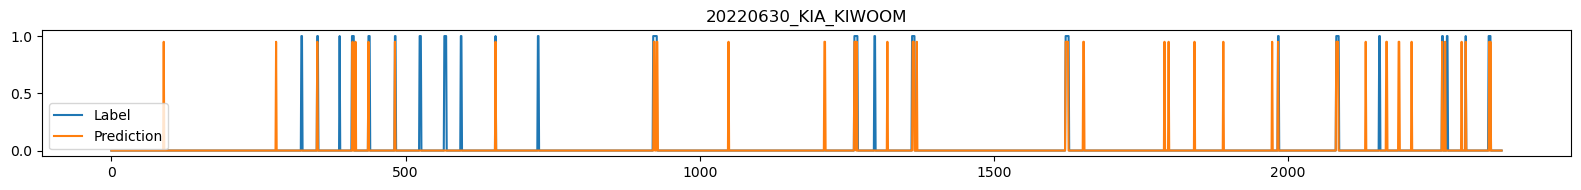

In [47]:
plot_predictions()

In [48]:
def print_false_predictions(title):
    from data_converter import to_hms
    
    pd.set_option('display.max_rows', None)
    
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
    
    title_segment_df['time'] = (title_segment_df['index'] * segment_length).apply(to_hms)
    
    columns = ['title', 'index', 'time', 'label', 'pred']
    print(title_segment_df[title_segment_df['label'] != title_segment_df['pred']][columns])

In [50]:
# 확인하고 싶은 영상 제목을 입력
print_false_predictions('20220630_KIA_KIWOOM')

                    title  index      time  label  pred
7349  20220630_KIA_KIWOOM     89  00:07:25      0     1
7540  20220630_KIA_KIWOOM    280  00:23:20      0     1
7583  20220630_KIA_KIWOOM    323  00:26:55      1     0
7584  20220630_KIA_KIWOOM    324  00:27:00      1     0
7611  20220630_KIA_KIWOOM    351  00:29:15      1     0
7648  20220630_KIA_KIWOOM    388  00:32:20      1     0
7669  20220630_KIA_KIWOOM    409  00:34:05      1     0
7671  20220630_KIA_KIWOOM    411  00:34:15      1     0
7672  20220630_KIA_KIWOOM    412  00:34:20      1     0
7675  20220630_KIA_KIWOOM    415  00:34:35      0     1
7698  20220630_KIA_KIWOOM    438  00:36:30      1     0
7699  20220630_KIA_KIWOOM    439  00:36:35      1     0
7743  20220630_KIA_KIWOOM    483  00:40:15      1     0
7784  20220630_KIA_KIWOOM    524  00:43:40      1     0
7785  20220630_KIA_KIWOOM    525  00:43:45      1     0
7786  20220630_KIA_KIWOOM    526  00:43:50      1     0
7826  20220630_KIA_KIWOOM    566  00:47:10      

In [53]:
def save_predictions():
    from data_converter import to_hms
    
    segment_length = data_loader.get_metadata()['config']['segment_length']
    
    segment_df = data_loader.test_segment_df.copy()
    segment_df['pred'] = y_pred
    segment_df['start_sec'] = (segment_df['index'] * segment_length)
    segment_df['end_sec'] = ((segment_df['index'] + 1) * segment_length)
    segment_df['start_time'] = segment_df['start_sec'].apply(to_hms)
    segment_df['end_time'] = segment_df['end_sec'].apply(to_hms)
    segment_df['start_frame'] = (segment_df['start_sec'] * 29.97).astype(np.int32)
    segment_df['end_frame'] = (segment_df['end_sec'] * 29.97 - 1).astype(np.int32)
    
    title_list = sorted(segment_df['title'].unique())
    
    for i, title in enumerate(title_list):
        title_segment_df = segment_df[segment_df['title'] == title].sort_values(by='index')
        
        columns = ['index', 'start_sec', 'end_sec', 'start_time', 'end_time', 'start_frame', 'end_frame', 'label', 'pred']
        title_segment_df.to_csv(title + '.csv', columns=columns, index=False)

In [54]:
save_predictions()